In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import math
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.io import excel

# Preparation of the LoS tables
## Saves LoS attribtute price for cars
## Needs shortest paths of the the road network

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_zippedpickles(model_path + 'de_road_los')
z = stepmodel.read_json(model_path + 'de_zones')
sm.zones = z.zones

car_los: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


In [7]:
# Scale time to hours
if sm.car_los['time'].mean() > 1000:
    sm.car_los['time'] = sm.car_los['time'] / 3600
assert sm.car_los['time'].mean() < 10
sm.car_los['time'].mean()

15.446834809107667

## Add cost to LoS table

In [8]:
# Data from parameters
parking_cost = params['parking_cost']
car_occ = params['car_occ']
urb_dict = sm.zones['urbanisation'].to_dict()
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

In [9]:
for seg in segments:
    sm.car_los[seg+'_price'] = (sm.car_los['length']/1000 * params['car_var_cost'][seg]
                                + sm.car_los['destination'].map(urb_dict).astype(int).map(parking_cost)
                               ) / car_occ[seg] \
                               + params['car_fix_cost'][seg] * sm.car_los['time']

In [10]:
sm.car_los.sample(2)

,origin,destination,time,link_path,access_time,in_vehicle_time,length,route_type,route_types,commuting_no_car_price,...,business_no_car_price,business_car_price,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price
133424,DE125_0,DEA53_0,30.171667,"[rl_170494, rl_170498, rl_170497, rl_420153, r...",300,108318,289585,car,"(car,)",267.894705,...,275.744705,37.54318,280.487226,26.381694,245.679468,27.419176,223.230648,20.768567,227.281337,18.211244
98342,DE245_10,DED44_5,13.957500,"[rl_355071, rl_354674, rl_355128, rl_354911, r...",300,49947,136621,car,"(car,)",123.655209,...,127.268287,15.897651,129.451101,11.171323,113.430319,11.610644,103.09792,8.794445,104.96231,7.711547


<Axes: xlabel='length'>

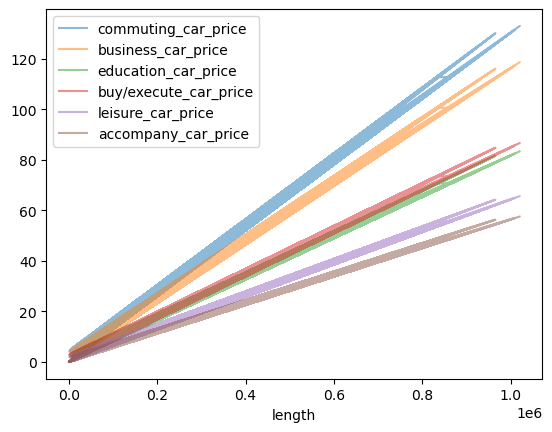

In [11]:
sm.car_los.set_index('length')[[s+'_price' for s in segments if len(s.split('_'))<3]].plot(alpha=.5)

## Save model

In [12]:
# Make table smaller
cols = ['access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [13]:
sm.to_zippedpickles(model_path + 'de_road_los', only_attributes=['car_los'])

zones: 100%|██████████████████████████████████████| 8/8 [00:13<00:00,  1.70s/it]
